importing Jupyter notebook from rutgers_socreward.ipynb


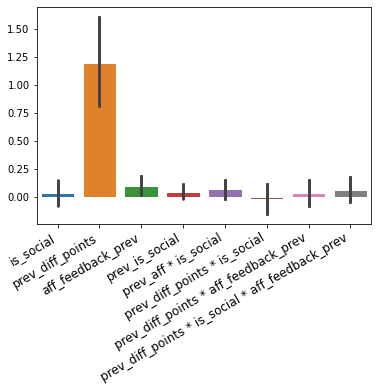

In [1]:
import pandas as pd
import numpy
import itertools
from utility import *
import import_ipynb
from rutgers_socreward import Subject, subject_list

In [2]:
#list of columns for making BIDS tsv file 
subset = ['deckchoice',
          'choice_onset',
          "press1_onset",
          "info_onset",
          "partner_onset",
          "press2_onset",
          'is_social', 
          'aff_feedback_prev_social', 
          'aff_feedback_prev_nonsocial',
          "aff_onset",
          "duration",
          'prev_diff_points',
          "RT1",
          "RT2", 
          'aff_feedback_curr',
          "lapse1",
          "lapse2",
          "is_catch"
]

#### Onset Type, Description : Duration

- choice_onset, Choose star or pentagon: RT1 or 3s 
- info_onset, Reveal choice value: 1.5s 
- partner-onset, Reveal Partner Choice: RT2 or 3s
- aff_onset,  Affective feedback win or lose: 1.5s

In [3]:
def generate_ev(sub, write = False):
    nan = 'n/a'
    for i in Subject(sub).matfiles:
        sub = sub
        run = Subject(sub).matfiles.index(i) + 1
        trial_dfs = []
        df = convert_mat(i)



        for index, row in df.iterrows():
            trial_df = pd.DataFrame()
            onset = []
            duration = []
            trial_type = []
            RT1 = []
            RT2 = []
            points = []
            
            #define strings for file naming
            if row.partner == 1:
                is_social = 'social'
            else:
                is_social = 'nonsocial'

            if row.deckchoice == 1:
                choice = 'star'
            elif row.deckchoice == 2:
                choice = 'pentagon'
            else:
                choice = nan
            
            #lapses or missed trials
            if row.lapse1 == 1 or row.lapse2 == 1:
                lapse = '_lapse'
                dur_choice = dur_partner = 3
            else:
                lapse = ''
                dur_choice = row.RT1 
                dur_partner = row.RT2

            #catch trials
            if row.is_catch == 1 or row.is_catch == 2:
                catch = '_catch'
                row.choice_onset = nan
                dur_choice = nan
            else:
                catch = ''
                
            if row.soc_win == 1: #win    
                win = '_win'
            elif row.soc_win == 0: #lose
                win = '_lose'
            else:
                pass
            
            #choice
            onset.append(row.choice_onset)
            duration.append(dur_choice)
            trial_type.append(f'partner-{is_social}_choice{lapse}{catch}')
            RT1.append(row.RT1)
            RT2.append('n/a')
            points.append('n/a')

            
            #info
            onset.append(row.info_onset)
            duration.append(1.5)
            trial_type.append(f'partner-{is_social}_feedback-informative{lapse}{catch}')
            RT1.append('n/a')
            RT2.append('n/a')
            points.append(row.Npoints)


            #partner
            onset.append(row.partner_onset)
            duration.append(dur_partner)
            trial_type.append(f'partner-{is_social}_feedback-partner{lapse}{catch}')
            RT1.append('n/a')
            RT2.append(row.RT2)
            points.append('n/a')


            #aff
            onset.append(row.aff_onset)
            duration.append(1.5)
            trial_type.append(f'partner-{is_social}_feedback-affective{win}{lapse}{catch}')
            RT1.append('n/a')
            RT2.append('n/a')
            points.append('n/a')


            trial_df['onset'] = onset
            trial_df['duration'] = duration
            trial_df['trial_type'] = trial_type
            trial_df['choice_RT'] = RT1
            trial_df['partner_RT'] = RT2
            trial_df['points'] = points


            trial_dfs.append(trial_df)

        bids_tsv = pd.concat(trial_dfs).reset_index()
        file_name = f'EVfiles/sub-{sub}_task-socreward_run-{run}_events.tsv'
        bids_tsv.to_csv(file_name, index = False)

    

In [4]:
for sub in subject_list:
    generate_ev(sub)

In [5]:
#fix index column for writing into BIDS tabular file standard

dfs = glob.glob('EVfiles/*.tsv')

for i in dfs:
    df = pd.read_csv(i, index_col=False)
    df['trialn'] = range(1, len(df) + 1)
    df = df.iloc[:, 1:]

    zero_indexNames = df[df['onset'] == 0].index
    
    df.drop(zero_indexNames , inplace=True)
    df = df.dropna(subset=['onset'])
    print(df)
    
    df.to_csv(i, sep ='\t', index = False)
    

          onset  duration                                 trial_type  \
1      9.784389  1.500000  partner-social_feedback-informative_catch   
4     22.332338  0.479372                   partner-nonsocial_choice   
5     26.329945  1.500000     partner-nonsocial_feedback-informative   
6     29.815556  1.339324         partner-nonsocial_feedback-partner   
7     37.831854  1.500000  partner-nonsocial_feedback-affective_lose   
..          ...       ...                                        ...   
149  736.826149  1.500000     partner-nonsocial_feedback-informative   
150  740.325994  0.751018         partner-nonsocial_feedback-partner   
151  745.342641  1.500000   partner-nonsocial_feedback-affective_win   
152  749.342477  3.000000             partner-nonsocial_choice_lapse   
156  765.858623  3.000000                partner-social_choice_lapse   

     choice_RT  partner_RT  points  trialn  
1          NaN         NaN    54.0       2  
4     0.479372         NaN     NaN       5  


          onset  duration                                trial_type  \
0      4.782948  1.324555                     partner-social_choice   
1     11.765803  1.500000       partner-social_feedback-informative   
2     18.265506  0.912831           partner-social_feedback-partner   
3     23.282760  1.500000     partner-social_feedback-affective_win   
4     28.032228  0.596743                  partner-nonsocial_choice   
..          ...       ...                                       ...   
155  761.308974  1.500000  partner-nonsocial_feedback-affective_win   
156  766.058605  0.915738                     partner-social_choice   
157  770.041496  1.500000       partner-social_feedback-informative   
158  773.541430  1.247797           partner-social_feedback-partner   
159  778.558401  1.500000    partner-social_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
0     1.324555         NaN     NaN       1  
1          NaN         NaN    40.0       2  
2          N

          onset  duration                                       trial_type  \
0      4.782932  0.604124                            partner-social_choice   
1     10.016188  1.500000              partner-social_feedback-informative   
2     16.266010  1.286984                  partner-social_feedback-partner   
3     24.015799  1.500000           partner-social_feedback-affective_lose   
4     28.282500  0.275226                            partner-social_choice   
..          ...       ...                                              ...   
155  752.033963  1.500000  partner-nonsocial_feedback-affective_lose_catch   
156  762.800464  0.638911                            partner-social_choice   
157  770.050461  1.500000              partner-social_feedback-informative   
158  773.283619  1.570532                  partner-social_feedback-partner   
159  779.033504  1.500000           partner-social_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
0     0.604124    

          onset  duration                                    trial_type  \
0      4.826142  3.000000                   partner-social_choice_lapse   
5     32.296030  1.500000  partner-nonsocial_feedback-informative_catch   
8     47.805670  0.650802                         partner-social_choice   
9     51.811263  1.500000           partner-social_feedback-informative   
10    58.290828  1.102384               partner-social_feedback-partner   
..          ...       ...                                           ...   
155  759.822891  1.500000     partner-nonsocial_feedback-affective_lose   
156  763.830537  1.655361                         partner-social_choice   
157  770.809092  1.500000           partner-social_feedback-informative   
158  774.315554  0.752758               partner-social_feedback-partner   
159  779.324898  1.500000        partner-social_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
0     0.000000         NaN     NaN       1  
5        

          onset  duration                                 trial_type  \
0      4.783034  1.678378                   partner-nonsocial_choice   
1     10.032832  1.500000     partner-nonsocial_feedback-informative   
2     14.265522  1.282863         partner-nonsocial_feedback-partner   
3     19.015626  1.500000  partner-nonsocial_feedback-affective_lose   
4     23.282390  1.961381                   partner-nonsocial_choice   
..          ...       ...                                        ...   
155  757.544838  1.500000      partner-social_feedback-affective_win   
156  761.811729  1.842289                      partner-social_choice   
157  767.061452  1.500000        partner-social_feedback-informative   
158  773.294360  1.033351            partner-social_feedback-partner   
159  779.044325  1.500000     partner-social_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
0     1.678378         NaN     NaN       1  
1          NaN         NaN    69.0       2  


          onset  duration                              trial_type  choice_RT  \
0      4.783131  0.685839                   partner-social_choice   0.685839   
1     11.765760  1.500000     partner-social_feedback-informative        NaN   
2     16.265674  1.200909         partner-social_feedback-partner        NaN   
3     22.282798  1.500000  partner-social_feedback-affective_lose        NaN   
4     26.282466  0.478998                   partner-social_choice   0.478998   
..          ...       ...                                     ...        ...   
155  761.064363  1.500000  partner-social_feedback-affective_lose        NaN   
156  765.814325  0.327786                   partner-social_choice   0.327786   
157  769.797099  1.500000     partner-social_feedback-informative        NaN   
158  773.297581  1.114426         partner-social_feedback-partner        NaN   
159  779.297711  1.500000   partner-social_feedback-affective_win        NaN   

     partner_RT  points  trialn  
0    

          onset  duration                                    trial_type  \
0      4.783243  0.460739                         partner-social_choice   
1      9.765880  1.500000           partner-social_feedback-informative   
2     16.265952  1.405471               partner-social_feedback-partner   
3     21.282520  1.500000        partner-social_feedback-affective_lose   
4     25.282456  0.233723                      partner-nonsocial_choice   
..          ...       ...                                           ...   
155  754.806864  1.500000  partner-social_feedback-affective_lose_catch   
156  766.056502  0.288668                         partner-social_choice   
157  770.039266  1.500000           partner-social_feedback-informative   
158  773.539019  1.231974               partner-social_feedback-partner   
159  778.555679  1.500000         partner-social_feedback-affective_win   

     choice_RT  partner_RT  points  trialn  
0     0.460739         NaN     NaN       1  
1        

          onset  duration                                    trial_type  \
1      9.765851  1.500000  partner-nonsocial_feedback-informative_catch   
4     25.032483  2.216985                         partner-social_choice   
5     29.015324  1.500000           partner-social_feedback-informative   
6     32.515187  2.022195               partner-social_feedback-partner   
7     40.532091  1.500000        partner-social_feedback-affective_lose   
..          ...       ...                                           ...   
155  761.798092  1.500000     partner-nonsocial_feedback-affective_lose   
156  765.814142  0.450306                      partner-nonsocial_choice   
157  769.797218  1.500000        partner-nonsocial_feedback-informative   
158  774.297087  1.274044            partner-nonsocial_feedback-partner   
159  779.313874  1.500000     partner-nonsocial_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
1          NaN         NaN    45.0       2  
4     2.2

          onset  duration                                 trial_type  \
0      4.783840  0.974756                      partner-social_choice   
1      9.766742  1.500000        partner-social_feedback-informative   
2     13.266207  1.379155            partner-social_feedback-partner   
3     21.282655  1.500000     partner-social_feedback-affective_lose   
4     26.033519  0.458833                      partner-social_choice   
..          ...       ...                                        ...   
155  754.566532  1.500000     partner-social_feedback-affective_lose   
156  760.067436  0.450649                   partner-nonsocial_choice   
157  767.049712  1.500000     partner-nonsocial_feedback-informative   
158  773.549080  1.407949         partner-nonsocial_feedback-partner   
159  778.566318  1.500000  partner-nonsocial_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
0     0.974756         NaN     NaN       1  
1          NaN         NaN    36.0       2  


          onset  duration                                 trial_type  \
0      4.783783  1.124597                      partner-social_choice   
1      9.032860  1.500000        partner-social_feedback-informative   
2     15.266039  1.271157            partner-social_feedback-partner   
3     21.015617  1.500000     partner-social_feedback-affective_lose   
4     26.033569  0.833547                      partner-social_choice   
..          ...       ...                                        ...   
153  744.799845  1.500000  partner-social_feedback-informative_catch   
156  760.816532  0.457303                   partner-nonsocial_choice   
157  768.050137  1.500000     partner-nonsocial_feedback-informative   
158  774.298992  1.664706         partner-nonsocial_feedback-partner   
159  779.049086  1.500000  partner-nonsocial_feedback-affective_lose   

     choice_RT  partner_RT  points  trialn  
0     1.124597         NaN     NaN       1  
1          NaN         NaN    87.0       2  
